In [2]:
import pandas as pd

df = pd.read_csv('data/DATASET_ic50_cleaned_compounds.csv')

In [3]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_murcko_scaffold(smiles):
    """Extract Murcko scaffold from SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

# Apply scaffold generation
print("Generating Murcko scaffolds...")
df['scaffold'] = df['smiles'].apply(get_murcko_scaffold)

# Filter out compounds where scaffold generation failed
df_valid = df[df['scaffold'].notna()].copy()

print(f"Compounds with valid scaffolds: {len(df_valid):,} / {len(df):,}")
print(f"Failed scaffold generation: {len(df) - len(df_valid):,}")


Generating Murcko scaffolds...
Compounds with valid scaffolds: 422 / 422
Failed scaffold generation: 0


In [4]:
from collections import Counter

# Count compounds per scaffold
scaffold_counts = Counter(df_valid['scaffold'])

print(f"Total unique scaffolds: {len(scaffold_counts):,}")
print(f"\nScaffold distribution:")
print(f"  Singletons (1 compound): {sum(1 for c in scaffold_counts.values() if c == 1):,}")
print(f"  Small series (2-5): {sum(1 for c in scaffold_counts.values() if 2 <= c <= 5):,}")
print(f"  Medium series (6-20): {sum(1 for c in scaffold_counts.values() if 6 <= c <= 20):,}")
print(f"  Large series (>20): {sum(1 for c in scaffold_counts.values() if c > 20):,}")

# Show top 10 most common scaffolds
print(f"\nTop 10 scaffolds by compound count:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"  {count:4d} compounds: {scaffold[:50]}..." if len(scaffold) > 50 else f"  {count:4d} compounds: {scaffold}")


Total unique scaffolds: 168

Scaffold distribution:
  Singletons (1 compound): 121
  Small series (2-5): 36
  Medium series (6-20): 7
  Large series (>20): 4

Top 10 scaffolds by compound count:
    50 compounds: c1ccc(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(C4)N5)c3...
    49 compounds: c1ccc2c(-c3cc4nc(OCC56CCCN5CCC6)nc(N5CC6CCC(C5)N6)...
    31 compounds: c1ccc2c(-c3cc4ncnc(N5CC6CCC(C5)N6)c4cn3)cccc2c1
    27 compounds: c1ccc2c(-c3cc4nc(OC[C@@H]5CCCN5)nc(N5CC6CCC(C5)N6)...
     9 compounds: c1ccc(C2CC2)c(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(...
     8 compounds: O=C1CNC(=O)C(Cc2ccccc2)NC(=O)CNC(=O)C2CCCN2C(=O)CC...
     8 compounds: c1ccc2c(-c3cc4nc(N5CCC5)nc(N5CC6CCC(C5)N6)c4cn3)cc...
     6 compounds: O=C1CNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)CNC(=O)C2C...
     6 compounds: c1cncc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc4...
     6 compounds: c1ccc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc45...


In [5]:
import numpy as np

# Prev: test_size=0.1; try test_size=0.2 this time
def scaffold_ic50_split(df, smiles_col='smiles', target_col = 'pIC50', test_size=0.2, val_size=0.1, n_bins = 5, random_state=42):
    """
    Perform scaffold-based train/validation/test split.
    
    All molecules sharing a scaffold are assigned to the same partition.
    Scaffolds are sorted by size (largest first) for balanced splits.

    Soft bin balancing is also done to ensure pIC50 are well distributed
    
    Returns: train_idx, val_idx, test_idx (lists of DataFrame indices)
    """
    np.random.seed(random_state)

    df['pIC50_bin'] = pd.qcut(df[target_col], q=n_bins, labels=False)
    
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    
    # Group indices by scaffold
    scaffold_to_indices = {}
    for idx, scaffold in zip(df.index, scaffolds):
        if scaffold is None:
            scaffold = f'NONE_{idx}'  # Treat parsing failures as singletons
        if scaffold not in scaffold_to_indices:
            scaffold_to_indices[scaffold] = []
        scaffold_to_indices[scaffold].append(idx)

    # Map scaffolds to their dominant bin
    scaffold_to_bin = {}
    for scaffold, indices in scaffold_to_indices.items():
        bins = df.loc[indices, 'pIC50_bin'].values
        # Dominant bin = mode
        dominant_bin = int(Counter(bins).most_common(1)[0][0])
        scaffold_to_bin[scaffold] = dominant_bin

    splits = {'train': [], 'val': [], 'test': []}
    split_targets = {
        'train': 1.0 - test_size - val_size,
        'val': val_size,
        'test': test_size
    }
    split_bin_counts = {
        'train': Counter(),
        'val': Counter(),
        'test': Counter()
    }
    split_sizes = {'train': 0, 'val': 0, 'test': 0}
    n_total = len(df)

    sorted_scaffolds = sorted(scaffold_to_indices.keys(),
                              key=lambda s: len(scaffold_to_indices[s]),
                              reverse=True)
    
    for scaffold in sorted_scaffolds:
        indices = scaffold_to_indices[scaffold]
        dominant_bin = scaffold_to_bin[scaffold]
        
        # Compute underrepresentation for this bin in each split
        underrep = {}
        for split in splits:
            target_count = split_targets[split] * n_total
            current_count = split_sizes[split]
            bin_count = split_bin_counts[split][dominant_bin]
            underrep[split] = (target_count - current_count) - bin_count
        
        # Assign scaffold to split where its bin is most underrepresented
        best_split = max(underrep, key=underrep.get)
        
        splits[best_split].extend(indices)
        split_sizes[best_split] += len(indices)
        split_bin_counts[best_split][dominant_bin] += len(indices)
    
    return splits['train'], splits['val'], splits['test']


In [6]:
# Perform scaffold-based split
train_idx, val_idx, test_idx = scaffold_ic50_split(
    df_valid,
    smiles_col='smiles',
    target_col='pIC50',
    test_size=0.2,
    val_size=0.1,
    n_bins = 5,
    random_state=42
)

# Create split DataFrames
df_train = df_valid.loc[train_idx].copy()
df_val = df_valid.loc[val_idx].copy()
df_test = df_valid.loc[test_idx].copy()

print(f"Scaffold-based split:")
print(f"  Train: {len(df_train):,} compounds ({100*len(df_train)/len(df_valid):.1f}%)")
print(f"  Val:   {len(df_val):,} compounds ({100*len(df_val)/len(df_valid):.1f}%)")
print(f"  Test:  {len(df_test):,} compounds ({100*len(df_test)/len(df_valid):.1f}%)")


Scaffold-based split:
  Train: 270 compounds (64.0%)
  Val:   58 compounds (13.7%)
  Test:  94 compounds (22.3%)


In [7]:
# Verify zero scaffold overlap
train_scaffolds = set(df_train['scaffold'])
val_scaffolds = set(df_val['scaffold'])
test_scaffolds = set(df_test['scaffold'])

train_val_overlap = train_scaffolds.intersection(val_scaffolds)
train_test_overlap = train_scaffolds.intersection(test_scaffolds)
val_test_overlap = val_scaffolds.intersection(test_scaffolds)

print("Scaffold Overlap Verification:")
print(f"  Train-Val overlap: {len(train_val_overlap)} scaffolds")
print(f"  Train-Test overlap: {len(train_test_overlap)} scaffolds")
print(f"  Val-Test overlap: {len(val_test_overlap)} scaffolds")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("\n[SUCCESS] Zero scaffold overlap - split integrity verified!")
else:
    print("\n[ERROR] Scaffold overlap detected - check implementation!")


Scaffold Overlap Verification:
  Train-Val overlap: 0 scaffolds
  Train-Test overlap: 0 scaffolds
  Val-Test overlap: 0 scaffolds

[SUCCESS] Zero scaffold overlap - split integrity verified!


In [8]:
# Analyze pIC50 distributions across splits
print("pIC50 Distribution Analysis:")
print(f"{'Partition':<10} {'Count':>8} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 58)

for name, data in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    print(f"{name:<10} {len(data):>8,} {data['pIC50'].mean():>8.2f} {data['pIC50'].std():>8.2f} {data['pIC50'].min():>8.2f} {data['pIC50'].max():>8.2f}")

print("-" * 58)
print(f"{'Total':<10} {len(df_valid):>8,} {df_valid['pIC50'].mean():>8.2f} {df_valid['pIC50'].std():>8.2f} {df_valid['pIC50'].min():>8.2f} {df_valid['pIC50'].max():>8.2f}")


pIC50 Distribution Analysis:
Partition     Count     Mean      Std      Min      Max
----------------------------------------------------------
Train           270     6.40     1.08     4.69     9.70
Val              58     7.17     1.25     5.05     9.15
Test             94     6.69     1.25     4.41     9.07
----------------------------------------------------------
Total           422     6.57     1.17     4.41     9.70


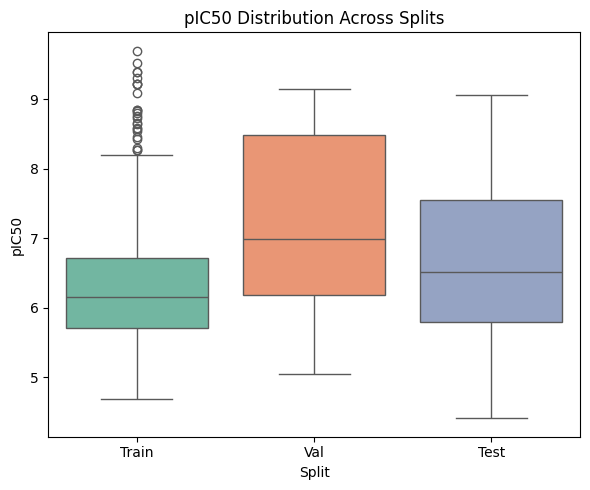

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data with labels
df_train['Split'] = 'Train'
df_val['Split'] = 'Val'
df_test['Split'] = 'Test'
df_combined = pd.concat([df_train, df_val, df_test])

# Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_combined, x='Split', y='pIC50', hue='Split',
            order=['Train', 'Val', 'Test'], palette='Set2', legend=False)
plt.title('pIC50 Distribution Across Splits')
plt.tight_layout()
plt.show()


In [10]:
# Create index mapping from SMILES to row position

df_ecfp4_final = pd.read_csv("data/DATASET_ecfp4.csv")
df_maccs_final = pd.read_csv("data/DATASET_maccs.csv")
df_rdkit_final = pd.read_csv("data/DATASET_rdkit.csv")
df_fingerprints_combined = pd.read_csv("data/DATASET_fp_combined.csv")

smiles_to_split = {}
for idx in train_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'train'
for idx in val_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'val'
for idx in test_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'test'
 
def split_by_smiles(df, smiles_col='smiles'):
    """Split DataFrame using SMILES-based assignment."""
    df['split'] = df[smiles_col].map(smiles_to_split)
    train = df[df['split'] == 'train'].drop(columns=['split'])
    val = df[df['split'] == 'val'].drop(columns=['split'])
    test = df[df['split'] == 'test'].drop(columns=['split'])
    return train, val, test
 
# Split all fingerprint datasets
fp_ecfp4_train, fp_ecfp4_val, fp_ecfp4_test = split_by_smiles(df_ecfp4_final)
fp_maccs_train, fp_maccs_val, fp_maccs_test = split_by_smiles(df_maccs_final)
fp_rdkit_train, fp_rdkit_val, fp_rdkit_test = split_by_smiles(df_rdkit_final)
fp_combined_train, fp_combined_val, fp_combined_test = split_by_smiles(df_fingerprints_combined)
 
print(f"ECFP4 split: train={len(fp_ecfp4_train)}, val={len(fp_ecfp4_val)}, test={len(fp_ecfp4_test)}")
print(f"MACCS split: train={len(fp_maccs_train)}, val={len(fp_maccs_val)}, test={len(fp_maccs_test)}")
print(f"RDKIT split: train={len(fp_rdkit_train)}, val={len(fp_rdkit_val)}, test={len(fp_rdkit_test)}")
print(f"Combined FP split: train={len(fp_combined_train)}, val={len(fp_combined_val)}, test={len(fp_combined_test)}")

ECFP4 split: train=270, val=58, test=94
MACCS split: train=270, val=58, test=94
RDKIT split: train=270, val=58, test=94
Combined FP split: train=270, val=58, test=94


In [11]:
# Split descriptor dataset
df_descriptors = pd.read_csv("data/DATASET_descriptors.csv")
desc_train, desc_val, desc_test = split_by_smiles(df_descriptors)
print(f"Descriptor split: train={len(desc_train)}, val={len(desc_val)}, test={len(desc_test)}")

Descriptor split: train=270, val=58, test=94


In [12]:
import os
import shutil

# Create splits directory
os.makedirs('splits', exist_ok=True)

# Save ECFP4 splits
fp_ecfp4_train.to_csv('splits/DATASET_ecfp4_train.csv', index=False)
fp_ecfp4_val.to_csv('splits/DATASET_ecfp4_val.csv', index=False)
fp_ecfp4_test.to_csv('splits/DATASET_ecfp4_test.csv', index=False)

# Save MACCS splits
fp_maccs_train.to_csv('splits/DATASET_maccs_train.csv', index=False)
fp_maccs_val.to_csv('splits/DATASET_maccs_val.csv', index=False)
fp_maccs_test.to_csv('splits/DATASET_maccs_test.csv', index=False)

# Save RDKit fingerprint splits
fp_rdkit_train.to_csv('splits/DATASET_rdkit_fp_train.csv', index=False)
fp_rdkit_val.to_csv('splits/DATASET_rdkit_fp_val.csv', index=False)
fp_rdkit_test.to_csv('splits/DATASET_rdkit_fp_test.csv', index=False)

# Save combined fingerprint splits
fp_combined_train.to_csv('splits/DATASET_fingerprints_combined_train.csv', index=False)
fp_combined_val.to_csv('splits/DATASET_fingerprints_combined_val.csv', index=False)
fp_combined_test.to_csv('splits/DATASET_fingerprints_combined_test.csv', index=False)

# Save descriptor splits
desc_train.to_csv('splits/DATASET_descriptors_train.csv', index=False)
desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test.to_csv('splits/DATASET_descriptors_test.csv', index=False)

print("All split datasets saved to 'splits/' directory")
print(f"Files created: {len(os.listdir('splits'))}")


All split datasets saved to 'splits/' directory
Files created: 15



ECFP4:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 270, Val: 58, Test: 94

MACCS:
  Feature columns: 167
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 270, Val: 58, Test: 94

RDKit Fingerprints:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 270, Val: 58, Test: 94

Combined Fingerprints:
  Feature columns: 4263
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 270, Val: 58, Test: 94

Descriptors:
  Feature columns: 89
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 270, Val: 58, Test: 94


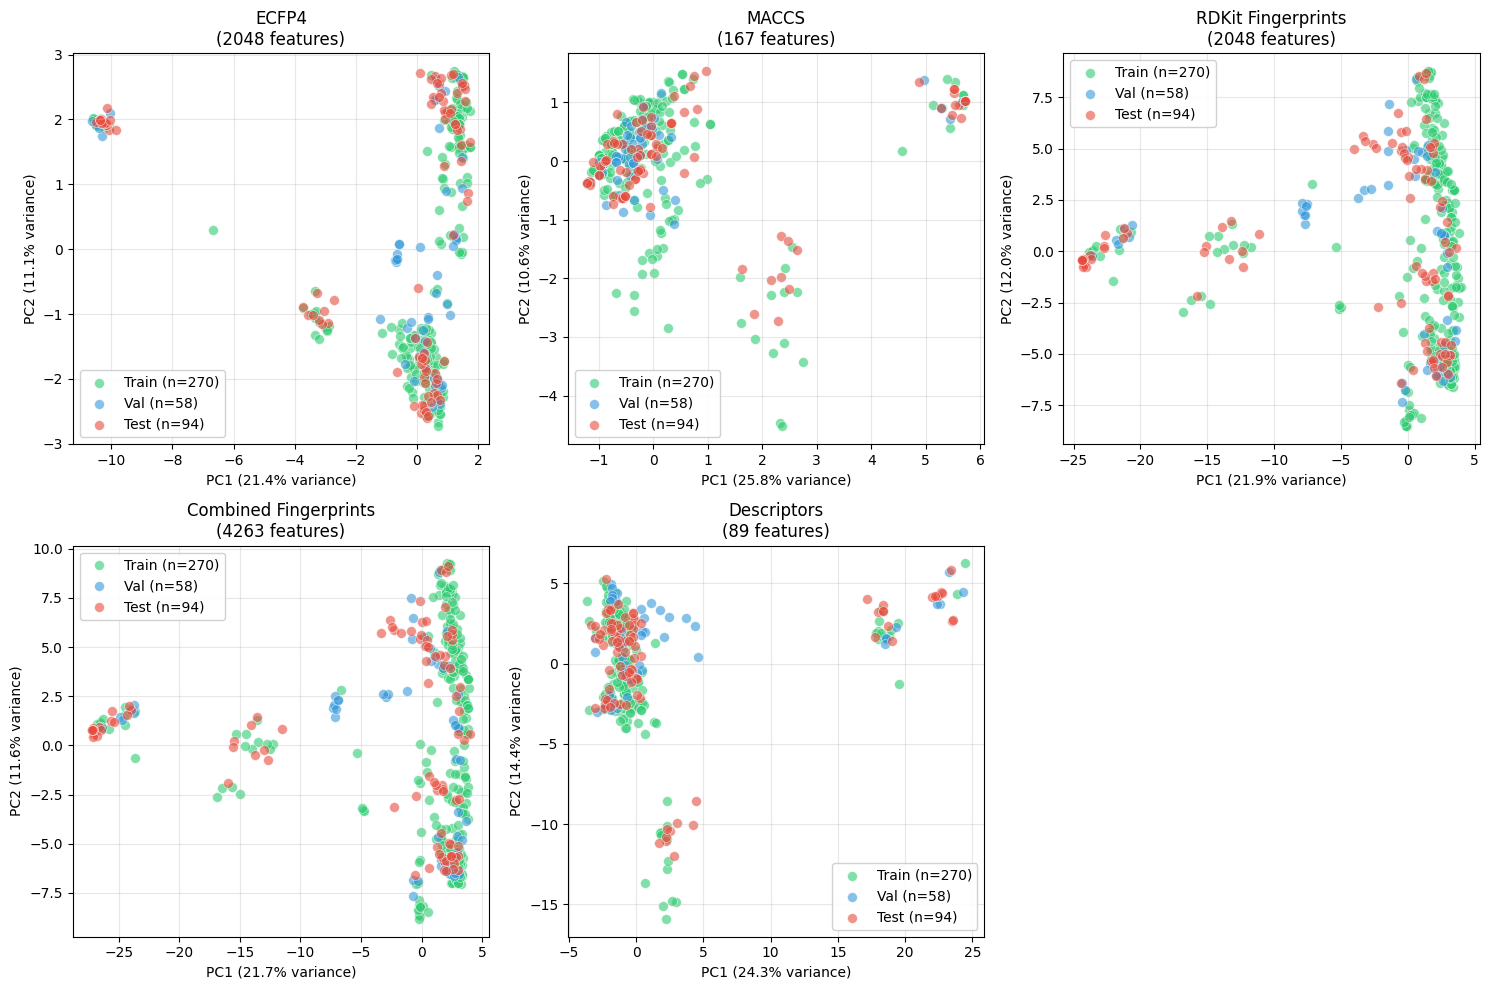

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the 5 methods and their file prefixes
methods = {
    'ECFP4': 'DATASET_ecfp4',
    'MACCS': 'DATASET_maccs',
    'RDKit Fingerprints': 'DATASET_rdkit_fp',
    'Combined Fingerprints': 'DATASET_fingerprints_combined',
    'Descriptors': 'DATASET_descriptors'
}

# Columns to exclude (non-feature columns)
EXCLUDE_COLS = ['molecule_chembl_id', 'smiles', 'pIC50']

def detect_feature_columns(df):
    """
    Detect feature columns by excluding specified non-feature columns.
    """
    non_feature_cols = [col for col in df.columns if col in EXCLUDE_COLS]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols, non_feature_cols

def load_splits(file_prefix, splits_dir='splits'):
    """
    Load train, validation, and test splits for a given method.
    """
    train_df = pd.read_csv(f'{splits_dir}/{file_prefix}_train.csv')
    val_df = pd.read_csv(f'{splits_dir}/{file_prefix}_val.csv')
    test_df = pd.read_csv(f'{splits_dir}/{file_prefix}_test.csv')
    return train_df, val_df, test_df

def plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=None):
    """
    Perform PCA and plot for train/val/test subsets of a given method.
    """
    # Load data
    train_df, val_df, test_df = load_splits(file_prefix, splits_dir)

    # Detect feature columns
    feature_cols, non_feature_cols = detect_feature_columns(train_df)

    print(f"\n{method_name}:")
    print(f"  Feature columns: {len(feature_cols)}")
    print(f"  Excluded columns: {non_feature_cols}")
    print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    # Extract features
    X_train = train_df[feature_cols].values.astype(float)
    X_val = val_df[feature_cols].values.astype(float)
    X_test = test_df[feature_cols].values.astype(float)

    # Only scale for Descriptors
    if method_name == 'Descriptors':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    # Perform PCA (fit on train, transform all)
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train)
    val_pca = pca.transform(X_val)
    test_pca = pca.transform(X_test)

    # Get explained variance
    var_explained = pca.explained_variance_ratio_ * 100

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label=f'Train (n={len(train_df)})',
               c='#2ecc71', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(val_pca[:, 0], val_pca[:, 1], alpha=0.6, label=f'Val (n={len(val_df)})',
               c='#3498db', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label=f'Test (n={len(test_df)})',
               c='#e74c3c', edgecolors='white', linewidth=0.5, s=50)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% variance)')
    ax.set_title(f'{method_name}\n({len(feature_cols)} features)')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)

    return pca, var_explained

# Main execution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method_name, file_prefix) in enumerate(methods.items()):
    plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=axes[idx])

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, set_name=''):
    """
    Calculate and display regression metrics.
    
    Returns dict with R², RMSE, and MAE.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    metrics = {'R2': r2, 'RMSE': rmse, 'MAE': mae}
    
    if set_name:
        print(f"{set_name:15} R²={r2:.3f}  RMSE={rmse:.3f}  MAE={mae:.3f}")
    
    return metrics

In [15]:
#feature selection

import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fp_ecfp4_train = pd.read_csv("splits/DATASET_ecfp4_train.csv")
fp_ecfp4_val = pd.read_csv("splits/DATASET_ecfp4_val.csv")
fp_ecfp4_test = pd.read_csv("splits/DATASET_ecfp4_test.csv")
fp_maccs_train = pd.read_csv("splits/DATASET_maccs_train.csv")
fp_maccs_val = pd.read_csv("splits/DATASET_maccs_val.csv")
fp_maccs_test = pd.read_csv("splits/DATASET_maccs_test.csv")
fp_rdkit_train = pd.read_csv("splits/DATASET_rdkit_fp_train.csv")
fp_rdkit_val = pd.read_csv("splits/DATASET_rdkit_fp_val.csv")
fp_rdkit_test = pd.read_csv("splits/DATASET_rdkit_fp_test.csv")
desc_train = pd.read_csv("splits/DATASET_descriptors_train.csv")
desc_val = pd.read_csv("splits/DATASET_descriptors_val.csv")
desc_test = pd.read_csv("splits/DATASET_descriptors_test.csv")
fp_combined_train = pd.read_csv("splits/DATASET_fingerprints_combined_train.csv")
fp_combined_val = pd.read_csv("splits/DATASET_fingerprints_combined_val.csv")
fp_combined_test = pd.read_csv("splits/DATASET_fingerprints_combined_test.csv")

feature_groups = {
    "ECFP4": (fp_ecfp4_train, fp_ecfp4_val, fp_ecfp4_test),
    "MACCS": (fp_maccs_train, fp_maccs_val, fp_maccs_test),
    "RDKit": (fp_rdkit_train, fp_rdkit_val, fp_rdkit_test),
    "Descriptors": (desc_train, desc_val, desc_test),
    "CombinedFP": (fp_combined_train, fp_combined_val, fp_combined_test)
}


In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# -----------------------------
# RF feature selection for fingerprints
# -----------------------------
def feature_selection_rf(train_df, target_col='pIC50',
                         metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50'],
                         random_state=42):
    feature_cols = [c for c in train_df.columns if c not in metadata_cols]

    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    # Train RF to get feature importance
    rf = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    ranked_idx = np.argsort(importances)[::-1]
    ranked_features = np.array(feature_cols)[ranked_idx]

    # Select top 10% or at least 20 features
    top_n = max(20, int(0.1 * len(ranked_features)))
    selected_feats = ranked_features[:top_n]
    print(f"RF: Selected top {top_n} features based on importance.")

    # Optional RFECV to refine
    #rf_rfe = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
    #rfecv = RFECV(rf_rfe, step=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    #rfecv.fit(X_train[:, ranked_idx[:top_n]], y_train)

    #final_feats = selected_feats[rfecv.support_]
    #print(f"RF: RFECV selected {len(final_feats)} features.")

    return list(selected_feats)

# -----------------------------
# LASSO feature selection for descriptors
# -----------------------------
def feature_selection_lasso(train_df, target_col='pIC50',
                            metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50'],
                            random_state=42):
    feature_cols = [c for c in train_df.columns if c not in metadata_cols]

    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    # Build pipeline: scale -> LASSO selection
    lasso = LassoCV(cv=5, random_state=random_state, n_jobs=-1, max_iter=20000)
    selector = SelectFromModel(lasso, prefit=False)  # will fit inside pipeline

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', selector)
    ])

    # Fit pipeline on training data
    pipeline.fit(X_train, y_train)

    # Get selected feature names
    mask = pipeline.named_steps['feature_selector'].get_support()
    selected_feats = np.array(feature_cols)[mask]
    print(f"LASSO: Selected {len(selected_feats)} features.")

    return pipeline, list(selected_feats), feature_cols

# -----------------------------
# Apply feature selection to all groups
# -----------------------------
selected_features = {}
scalers = {}  # for descriptors

for name, (train_df, val_df, test_df) in feature_groups.items():
    print(f"\n=== Feature selection for {name} ===")
    if name == 'Descriptors':
        scaler, feats, all_cols = feature_selection_lasso(train_df)
        selected_features[name] = all_cols
        scalers[name] = scaler
    else:
        feats = feature_selection_rf(train_df)
        selected_features[name] = feats



=== Feature selection for ECFP4 ===
RF: Selected top 204 features based on importance.

=== Feature selection for MACCS ===
RF: Selected top 20 features based on importance.

=== Feature selection for RDKit ===
RF: Selected top 204 features based on importance.

=== Feature selection for Descriptors ===
LASSO: Selected 43 features.

=== Feature selection for CombinedFP ===
RF: Selected top 426 features based on importance.


In [17]:
# -----------------------------
# Function to prepare X matrices for baseline model
# -----------------------------
def prepare_X(df, selected_feats, scaler=None):
    if scaler is not None:
        X = scaler.transform(df[selected_feats].values)
    else:
        X = df[selected_feats].values
    return X

# -----------------------------
# Train baseline Random Forest on train set and evaluate
# -----------------------------
results = {}

for name, (train_df, val_df, test_df) in feature_groups.items():
    print(f"Running Baseline Model for : {name}")
    feats = selected_features[name]
    scaler = scalers.get(name, None)

    X_train = prepare_X(train_df, feats, scaler)
    y_train = train_df['pIC50'].values

    X_val = prepare_X(val_df, feats, scaler)
    y_val = val_df['pIC50'].values

    X_trainval = np.vstack([X_train, X_val])
    y_trainval = np.concatenate([y_train, y_val])

    X_test = prepare_X(test_df, feats, scaler)
    y_test = test_df['pIC50'].values

    # Train RF baseline
    rf_baseline = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf_baseline.fit(X_train, y_train)

    # Evaluate
    y_train_pred = rf_baseline.predict(X_train)
    y_val_pred = rf_baseline.predict(X_val)
    y_test_pred = rf_baseline.predict(X_test)

    # Combine Train+Val metrics
    y_trainval = np.concatenate([y_train, y_val])
    y_trainval_pred = np.concatenate([y_train_pred, y_val_pred])

    results[f'RF_{name}_baseline_trainval'] = evaluate_model(
        y_trainval, rf_baseline.predict(X_trainval), 'Train+Val')
    results[f'RF_{name}_baseline_test'] = evaluate_model(
        y_test, rf_baseline.predict(X_test), 'Test')

Running Baseline Model for : ECFP4
Train+Val       R²=0.865  RMSE=0.420  MAE=0.253
Test            R²=0.479  RMSE=0.895  MAE=0.663
Running Baseline Model for : MACCS
Train+Val       R²=0.654  RMSE=0.672  MAE=0.436
Test            R²=0.436  RMSE=0.931  MAE=0.692
Running Baseline Model for : RDKit
Train+Val       R²=0.853  RMSE=0.437  MAE=0.258
Test            R²=0.560  RMSE=0.822  MAE=0.649
Running Baseline Model for : Descriptors
Train+Val       R²=0.804  RMSE=0.505  MAE=0.298
Test            R²=0.407  RMSE=0.955  MAE=0.748
Running Baseline Model for : CombinedFP
Train+Val       R²=0.875  RMSE=0.404  MAE=0.248
Test            R²=0.570  RMSE=0.813  MAE=0.630


In [18]:
#fine tuning for best performing CombinedFP model

from sklearn.model_selection import GridSearchCV

# Define Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],       # Number of trees
    'max_depth': [10, 20, None],       # Tree depth (None = unlimited)
    'min_samples_split': [2, 5],       # Min samples to split node
    'min_samples_leaf': [1, 3],         # Min samples per leaf
    'max_features': ['sqrt', 'log2']       # Features per split
}

# Calculate total combinations
n_combinations = (len(rf_param_grid['n_estimators']) *
                  len(rf_param_grid['max_depth']) *
                  len(rf_param_grid['min_samples_split']) *
                  len(rf_param_grid['min_samples_leaf']) *
                  len(rf_param_grid['max_features']))

print(f"Random Forest parameter grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {n_combinations}")
print(f"Total fits (with 5-fold CV): {n_combinations * 5}")


Random Forest parameter grid:
  n_estimators: [100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 3]
  max_features: ['sqrt', 'log2']

Total combinations: 48
Total fits (with 5-fold CV): 240


In [19]:
# Run GridSearchCV for Random Forest
print("Running GridSearchCV for Random Forest")
print("This may take several minutes.\n")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the search space
rf_param_dist = {
    'n_estimators': [100, 200, 500, 1000],          # More trees usually help
    'max_depth': [None, 10, 20, 30, 40],            # None allows full growth
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],         # Feature selection
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,                              # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1,                         # Parallel processing
    return_train_score=True,           # Track overfitting
    verbose=0                          # Hide progress
)

feats = selected_features["CombinedFP"]
scaler = scalers.get("CombinedFP", None)

X_train_fp = prepare_X(feature_groups["CombinedFP"][0], feats, scaler)
y_train = train_df['pIC50'].values

X_val_fp = prepare_X(feature_groups["CombinedFP"][1], feats, scaler)
y_val = val_df['pIC50'].values

X_trainval_fp = np.vstack([X_train_fp, X_val_fp])
y_trainval = np.concatenate([y_train, y_val])

X_test = prepare_X(feature_groups["CombinedFP"][2], feats, scaler)
y_test = test_df['pIC50'].values

# Fit to your training data
rf_grid_search.fit(X_trainval_fp, y_trainval)

print(f"\nBest parameters found:")
for param, value in rf_grid_search.best_params_.items():
    print(f"  {param}: {value}")

Running GridSearchCV for Random Forest
This may take several minutes.


Best parameters found:
  max_depth: 20
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200


In [20]:
rf_optimized = rf_grid_search.best_estimator_

results['RF_CombinedFP_optimized_trainval'] = evaluate_model(
    y_trainval, rf_optimized.predict(X_trainval_fp), 'Train+Val')
results['RF_CombinedFP_optimized_test'] = evaluate_model(
    y_test, rf_optimized.predict(X_test), 'Test')

# Compare with baseline
baseline_test_r2 = results['RF_CombinedFP_baseline_test']['R2']
optimized_test_r2 = results['RF_CombinedFP_optimized_test']['R2']
improvement = optimized_test_r2 - baseline_test_r2
 
print(f"\nImprovement over baseline:")
print(f"  Baseline Test R²:  {baseline_test_r2:.4f}")
print(f"  Optimized Test R²: {optimized_test_r2:.4f}")
print(f"  Improvement:       {improvement:+.4f}")

Train+Val       R²=0.932  RMSE=0.297  MAE=0.234
Test            R²=0.648  RMSE=0.736  MAE=0.561

Improvement over baseline:
  Baseline Test R²:  0.5705
  Optimized Test R²: 0.6476
  Improvement:       +0.0771


In [21]:
from sklearn.svm import SVR
 
# SVR works best with scaled features - use descriptors
print("Training Support Vector Regression Baseline (Descriptors)...")
svr_baseline = SVR(
    kernel='rbf',     # Radial basis function kernel
    C=1.0,            # Default regularization
    epsilon=0.1,      # Default epsilon-tube width
    gamma='scale'     # Default kernel coefficient
)
 
svr_baseline.fit(X_trainval_fp, y_trainval)
 
print("\nSVR Baseline (Descriptors) Performance:")
results['SVR_baseline_trainval'] = evaluate_model(
    y_trainval, svr_baseline.predict(X_trainval_fp), 'Train+Val')
results['SVR_baseline_test'] = evaluate_model(
    y_test, svr_baseline.predict(X_test), 'Test')


Training Support Vector Regression Baseline (Descriptors)...

SVR Baseline (Descriptors) Performance:
Train+Val       R²=0.916  RMSE=0.331  MAE=0.224
Test            R²=0.662  RMSE=0.721  MAE=0.550


In [22]:
# Define SVR parameter grid
svr_param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],           # Regularization (higher = less regularization)
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2, 0.5]        # Epsilon-tube width
}
 
n_svr_combinations = (len(svr_param_grid['C']) * 
                      len(svr_param_grid['gamma']) * 
                      len(svr_param_grid['epsilon']))
 
print(f"SVR parameter grid:")
for param, values in svr_param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {n_svr_combinations}")
print(f"Total fits (with 5-fold CV): {n_svr_combinations * 5}")


SVR parameter grid:
  C: [0.1, 1.0, 10.0, 100.0]
  gamma: ['scale', 'auto', 0.01, 0.1]
  epsilon: [0.01, 0.1, 0.2, 0.5]

Total combinations: 64
Total fits (with 5-fold CV): 320


In [23]:
# Run GridSearchCV for SVR
print("Running GridSearchCV for SVR...")
print("This may take several minutes.\n")
 
svr_grid_search = GridSearchCV(
    estimator=SVR(kernel='rbf'),
    param_grid=svr_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True,
    verbose=1
)
 
svr_grid_search.fit(X_trainval_fp, y_trainval)

print(f"\nBest parameters found:")
for param, value in svr_grid_search.best_params_.items():
    print(f"  {param}: {value}")

Running GridSearchCV for SVR...
This may take several minutes.

Fitting 5 folds for each of 64 candidates, totalling 320 fits

Best parameters found:
  C: 10.0
  epsilon: 0.01
  gamma: 0.01


In [24]:
# Get the best SVR model
svr_optimized = svr_grid_search.best_estimator_
 
print("Optimized SVR (Descriptors) Performance:")
results['SVR_optimized_trainval'] = evaluate_model(
    y_trainval, svr_optimized.predict(X_trainval_fp), 'Train+Val')
results['SVR_optimized_test'] = evaluate_model(
    y_test, svr_optimized.predict(X_test), 'Test')
 
# Compare with baseline
svr_baseline_test_r2 = results['SVR_baseline_test']['R2']
svr_optimized_test_r2 = results['SVR_optimized_test']['R2']
svr_improvement = svr_optimized_test_r2 - svr_baseline_test_r2
 
print(f"\nImprovement over baseline:")
print(f"  Baseline Test R²:  {svr_baseline_test_r2:.4f}")
print(f"  Optimized Test R²: {svr_optimized_test_r2:.4f}")
print(f"  Improvement:       {svr_improvement:+.4f}")

Optimized SVR (Descriptors) Performance:
Train+Val       R²=0.990  RMSE=0.115  MAE=0.030
Test            R²=0.691  RMSE=0.689  MAE=0.525

Improvement over baseline:
  Baseline Test R²:  0.6619
  Optimized Test R²: 0.6910
  Improvement:       +0.0291


In [25]:
import xgboost as nb
from xgboost import XGBRegressor

# XGBoost works well with both fingerprints and descriptors
print("Training XGBoost Regressor Baseline...")
xgb_baseline = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.5,
    reg_lambda=5.0,
    reg_alpha=0.0,
    min_child_weight=5,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

# Training
xgb_baseline.fit(X_trainval_fp, y_trainval)

print("\nXGBoost Baseline Performance:")
results['XGB_baseline_trainval'] = evaluate_model(
    y_trainval, xgb_baseline.predict(X_trainval_fp), 'Train+Val')
results['XGB_baseline_test'] = evaluate_model(
    y_test, xgb_baseline.predict(X_test), 'Test')

# XGBoost: max_depth=4–6, learning_rate=0.03–0.1, subsample=0.7–0.9, colsample_bytree=0.3–0.7, reg_lambda=1–10, 
# reg_alpha=0–1, many trees + early stopping

Training XGBoost Regressor Baseline...

XGBoost Baseline Performance:
Train+Val       R²=0.997  RMSE=0.063  MAE=0.012
Test            R²=0.655  RMSE=0.728  MAE=0.559


In [26]:
# XGBoost parameter grid (basic)
xgb_param_grid = {
    "n_estimators": [300, 800, 2000],         # use larger values than 100–500 for QSAR
    "max_depth": [3, 4, 5, 6],                # avoid very deep trees first
    "learning_rate": [0.03, 0.05, 0.1],       # 0.2 is often too aggressive
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.3, 0.5, 0.8]
}

n_xgb_combinations = 1
for k, v in xgb_param_grid.items():
    n_xgb_combinations *= len(v)

print("XGBoost parameter grid:")
for param, values in xgb_param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {n_xgb_combinations}")
print(f"Total fits (with 5-fold CV): {n_xgb_combinations * 5}")


XGBoost parameter grid:
  n_estimators: [300, 800, 2000]
  max_depth: [3, 4, 5, 6]
  learning_rate: [0.03, 0.05, 0.1]
  subsample: [0.6, 0.8, 1.0]
  colsample_bytree: [0.3, 0.5, 0.8]

Total combinations: 324
Total fits (with 5-fold CV): 1620


In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Run GridSearchCV for XGBoost
print("Running GridSearchCV for XGBoost...")
print("This may take several minutes depending on the grid size.\n")

xgb_grid_search = GridSearchCV(
    estimator=XGBRegressor(
        objective='reg:squarederror', 
        random_state=42, 
        n_jobs=-1
    ),
    param_grid=xgb_param_grid,       # Use the XGBoost grid we defined
    cv=5,                            # 5-fold Cross-Validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,                       # Use all CPU cores
    return_train_score=True,
    verbose=1
)

# Fit using the same training data
xgb_grid_search.fit(X_trainval_fp, y_trainval)

print(f"\nBest XGBoost parameters found:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"  {param}: {value}")

Running GridSearchCV for XGBoost...
This may take several minutes depending on the grid size.

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best XGBoost parameters found:
  colsample_bytree: 0.5
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 300
  subsample: 0.6


In [28]:
# 1. Get the best XGB model from your grid search
xgb_optimized = xgb_grid_search.best_estimator_

print("Optimized XGBoost Performance:")

# 2. Evaluate on the combined Train+Val set
results['XGB_optimized_trainval'] = evaluate_model(
    y_trainval, xgb_optimized.predict(X_trainval_fp), 'Train+Val')

# 3. Evaluate on the final Test set
results['XGB_optimized_test'] = evaluate_model(
    y_test, xgb_optimized.predict(X_test), 'Test')

# 4. Compare with the XGB baseline you ran earlier
# (Assuming you stored the baseline results in 'XGB_baseline_test')
xgb_baseline_test_r2 = results['XGB_baseline_test']['R2']
xgb_optimized_test_r2 = results['XGB_optimized_test']['R2']
xgb_improvement = xgb_optimized_test_r2 - xgb_baseline_test_r2

print(f"\nXGBoost Improvement over baseline:")
print(f"  Baseline Test R²:  {xgb_baseline_test_r2:.4f}")
print(f"  Optimized Test R²: {xgb_optimized_test_r2:.4f}")
print(f"  Improvement:       {xgb_improvement:+.4f}")

Optimized XGBoost Performance:
Train+Val       R²=0.980  RMSE=0.162  MAE=0.120
Test            R²=0.627  RMSE=0.757  MAE=0.583

XGBoost Improvement over baseline:
  Baseline Test R²:  0.6551
  Optimized Test R²: 0.6273
  Improvement:       -0.0279


In [29]:
from lightgbm import LGBMRegressor

# LightGBM is robust and fast, works well with fingerprints or descriptors
print("Training LightGBM Regressor Baseline...")
lgbm_baseline = LGBMRegressor(
    n_estimators=100,      # Number of boosting iterations
    learning_rate=0.1,     # Step size shrinkage
    num_leaves=31,         # Main parameter to control tree complexity
    random_state=42,
    n_jobs=-1,             # Use all available CPU cores
    importance_type='gain' # Use 'gain' for more meaningful feature importance
)

# Training
lgbm_baseline.fit(X_trainval_fp, y_trainval)

print("\nLightGBM Baseline Performance:")
results['LGBM_baseline_trainval'] = evaluate_model(
    y_trainval, lgbm_baseline.predict(X_trainval_fp), 'Train+Val')
results['LGBM_baseline_test'] = evaluate_model(
    y_test, lgbm_baseline.predict(X_test), 'Test')

Training LightGBM Regressor Baseline...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 774
[LightGBM] [Info] Number of data points in the train set: 328, number of used features: 387
[LightGBM] [Info] Start training from score 6.533731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

c:\Users\kheef\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kheef\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [30]:
# Define LightGBM parameter grid
lgbm_param_grid = {
    'n_estimators': [50, 100, 200],          # Number of boosting iterations
    'learning_rate': [0.01, 0.05, 0.1],      # Step size shrinkage
    'num_leaves': [15, 31, 63],              # Max leaves in one tree (main complexity control)
    'min_data_in_leaf': [5, 10, 20],         # Min points in a leaf (crucial for small datasets)
    'lambda_l1': [0.0, 0.1, 1.0],            # L1 regularization
    'lambda_l2': [0.0, 0.1, 1.0]             # L2 regularization
}

n_lgbm_combinations = (len(lgbm_param_grid['n_estimators']) * len(lgbm_param_grid['learning_rate']) * len(lgbm_param_grid['num_leaves']) *
                       len(lgbm_param_grid['min_data_in_leaf']) *
                       len(lgbm_param_grid['lambda_l1']) *
                       len(lgbm_param_grid['lambda_l2']))

print(f"LightGBM parameter grid:")
for param, values in lgbm_param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations: {n_lgbm_combinations}")
print(f"Total fits (with 5-fold CV): {n_lgbm_combinations * 5}")

LightGBM parameter grid:
  n_estimators: [50, 100, 200]
  learning_rate: [0.01, 0.05, 0.1]
  num_leaves: [15, 31, 63]
  min_data_in_leaf: [5, 10, 20]
  lambda_l1: [0.0, 0.1, 1.0]
  lambda_l2: [0.0, 0.1, 1.0]

Total combinations: 729
Total fits (with 5-fold CV): 3645


In [31]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Run GridSearchCV for LightGBM
print("Running GridSearchCV for LightGBM...")
print("This may take several minutes given the number of combinations.\n")

lgbm_grid_search = GridSearchCV(
    estimator=LGBMRegressor(
        random_state=42, 
        # We set n_jobs=1 inside the model so GridSearchCV 
        # can manage the parallel threads efficiently
        n_jobs=1 
    ),
    param_grid=lgbm_param_grid,       # Use the LightGBM grid we defined
    cv=5,                             # 5-fold Cross-Validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,                        # Run combinations in parallel
    return_train_score=True,
    verbose=1
)

# Fit using your training data
lgbm_grid_search.fit(X_trainval_fp, y_trainval)

print(f"\nBest LightGBM parameters found:")
for param, value in lgbm_grid_search.best_params_.items():
    print(f"  {param}: {value}")

Running GridSearchCV for LightGBM...
This may take several minutes given the number of combinations.

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

In [32]:
# Get the best LightGBM  model
lgbm_optimized = lgbm_grid_search.best_estimator_

print("Optimized LightGBM Performance:")

# 2. Evaluate on the combined Train+Val set 
# (This will show if we successfully reduced the 0.94 R² to something more robust)
results['LGBM_optimized_trainval'] = evaluate_model(
    y_trainval, lgbm_optimized.predict(X_trainval_fp), 'Train+Val')

# 3. Evaluate on the final Test set
results['LGBM_optimized_test'] = evaluate_model(
    y_test, lgbm_optimized.predict(X_test), 'Test')

# 4. Compare with the LightGBM baseline
lgbm_baseline_test_r2 = results['LGBM_baseline_test']['R2']
lgbm_optimized_test_r2 = results['LGBM_optimized_test']['R2']
lgbm_improvement = lgbm_optimized_test_r2 - lgbm_baseline_test_r2

print(f"\nLightGBM Improvement over baseline:")
print(f"  Baseline Test R²:  {lgbm_baseline_test_r2:.4f}")
print(f"  Optimized Test R²: {lgbm_optimized_test_r2:.4f}")
print(f"  Improvement:       {lgbm_improvement:+.4f}")

Optimized LightGBM Performance:
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
Train+Val       R²=0.979  RMSE=0.164  MAE=0.116
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
Test            R²=0.663  RMSE=0.720  MAE=0.568

LightGBM Improvement over baseline:
  Baseline Test R²:  0.6529
  Optimized Test R²: 0.6627
  Improvement:       +0.0099


c:\Users\kheef\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\kheef\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [33]:
# # Try transfer learning (ensemble learning didn't go too well)

# import pandas as pd
# from simpletransformers.classification import ClassificationModel
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_squared_error

# # 1. Prepare Data: Transformers expect 'text' (SMILES) and 'labels' (pIC50)
# # Note: Since pIC50 is continuous, we use a Regression model
# train_df = pd.DataFrame({
#     'text': X_trainval_smiles, # Your SMILES strings
#     'labels': y_trainval      # Your experimental pIC50 values
# })

# eval_df = pd.DataFrame({
#     'text': X_test_smiles,
#     'labels': y_test
# })

# # 2. Define Hyperparameters
# # For small datasets, use a low learning rate and few epochs to prevent overfitting
# model_args = {
#     "num_train_epochs": 10,
#     "learning_rate": 1e-5,
#     "overwrite_output_dir": True,
#     "regression": True, # Crucial for pIC50 prediction
#     "train_batch_size": 16,
#     "manual_seed": 42
# }

# # 3. Initialize Model (using ChemBERTa pre-trained weights)
# model = ClassificationModel(
#     "roberta", 
#     "DeepChem/ChemBERTa-77M-MTR", 
#     num_labels=1, 
#     args=model_args,
#     use_cuda=True # Set to False if you don't have a GPU
# )

# # 4. Fine-tune the model
# print("Starting Transfer Learning (Fine-tuning)...")
# model.train_model(train_df)

# # 5. Evaluate on Test Set
# predictions, _ = model.predict(eval_df['text'].tolist())
# test_r2 = r2_score(y_test, predictions)

# print(f"\nChemBERTa Fine-tuned Test R²: {test_r2:.4f}")

In [34]:
# # Duo Ensemble: XGB + LGBM
# # Duo-Ensemble Test R²: 0.6561

# from sklearn.linear_model import Ridge
# from sklearn.model_selection import cross_val_predict

# # 1. Generate Out-of-Fold (OOF) predictions for the training set
# print("Generating OOF predictions for the Duo-Ensemble...")

# # Using cross_val_predict ensures the Meta-Learner doesn't "cheat"
# # Note: Ensure these models were trained on the same feature set (e.g., fingerprints)
# xgb_oof = cross_val_predict(xgb_optimized, X_trainval_fp, y_trainval, cv=5)
# lgbm_oof = cross_val_predict(lgbm_optimized, X_trainval_fp, y_trainval, cv=5)

# # 2. Create the Meta-Feature Matrix (Training)
# X_meta_train = np.column_stack((xgb_oof, lgbm_oof))

# # 3. Train the Meta-Learner (Ridge)
# # alpha=1.0 provides a good balance of regularization
# meta_learner = Ridge(alpha=1.0)
# meta_learner.fit(X_meta_train, y_trainval)

# # 4. Generate Predictions for the Test Set
# print("Generating final Test predictions...")
# xgb_test = xgb_optimized.predict(X_test)
# lgbm_test = lgbm_optimized.predict(X_test)

# # 5. Combine and run through Meta-Learner
# X_meta_test = np.column_stack((xgb_test, lgbm_test))
# ensemble_preds = meta_learner.predict(X_meta_test)

# # 6. Evaluate
# results['Duo_Ensemble_test'] = evaluate_model(y_test, ensemble_preds, 'Test')

# print(f"\nIndividual Best (LGBM) R²: {results['LGBM_optimized_test']['R2']:.4f}")
# print(f"Duo-Ensemble Test R²:     {results['Duo_Ensemble_test']['R2']:.4f}")

In [35]:
# # Super-Ensemble: XGB + LGBM + SVR
# # Super-Ensemble Test R²: 0.6233

# from sklearn.linear_model import Ridge
# from sklearn.model_selection import cross_val_predict

# # 1. Generate Out-of-Fold (OOF) predictions for the training set
# print("Generating OOF predictions for the Super-Ensemble...")

# # Using cross_val_predict ensures the Meta-Learner doesn't "cheat"
# # Note: Ensure these models were trained on the same feature set (e.g., fingerprints)
# xgb_oof = cross_val_predict(xgb_optimized, X_trainval_fp, y_trainval, cv=5)
# lgbm_oof = cross_val_predict(lgbm_optimized, X_trainval_fp, y_trainval, cv=5)
# svr_oof = cross_val_predict(svr_optimized, X_trainval_fp, y_trainval, cv=5)

# # 2. Create the Meta-Feature Matrix (Training)
# X_meta_train = np.column_stack((xgb_oof, lgbm_oof, svr_oof))

# # 3. Train the Meta-Learner (Ridge)
# # alpha=1.0 provides a good balance of regularization
# meta_learner = Ridge(alpha=1.0)
# meta_learner.fit(X_meta_train, y_trainval)

# # 4. Generate Predictions for the Test Set
# print("Generating final Test predictions...")
# xgb_test = xgb_optimized.predict(X_test)
# lgbm_test = lgbm_optimized.predict(X_test)
# svr_test = svr_optimized.predict(X_test)

# # 5. Combine and run through Meta-Learner
# X_meta_test = np.column_stack((xgb_test, lgbm_test, svr_test))
# ensemble_preds = meta_learner.predict(X_meta_test)

# # 6. Evaluate
# results['Super_Ensemble_test'] = evaluate_model(y_test, ensemble_preds, 'Test')

# print(f"\nIndividual Best (LGBM) R²: {results['LGBM_optimized_test']['R2']:.4f}")
# print(f"Super-Ensemble Test R²:     {results['Super_Ensemble_test']['R2']:.4f}")

In [37]:
# Create comprehensive summary table
summary_data = []
 
model_configs = [
    ('Random Forest (FP) - Baseline', 'RF_CombinedFP_baseline'),
    ('Random Forest (FP) - Optimized', 'RF_CombinedFP_optimized'),
    ('SVR - Baseline', 'SVR_baseline'),
    ('SVR - Optimized', 'SVR_optimized'),
    ('XGB - Baseline', 'XGB_baseline'),
    ('XGB - Optimized', 'XGB_optimized'),
    ('LightGBM - Baseline', 'LGBM_baseline'),
    ('LightGBM - Optimized', 'LGBM_optimized'),
]

for name, prefix in model_configs:
    if f'{prefix}_test' in results:
        summary_data.append({
            'Model': name,
            'Train+Val R²': results[f'{prefix}_trainval']['R2'],
            'Test R²': results[f'{prefix}_test']['R2'],
            'Test RMSE': results[f'{prefix}_test']['RMSE'],
            'Test MAE': results[f'{prefix}_test']['MAE'],
        })
 
df_summary = pd.DataFrame(summary_data)
 
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(df_summary.to_string(index=False))
print("=" * 90)


MODEL COMPARISON SUMMARY
                         Model  Train+Val R²  Test R²  Test RMSE  Test MAE
 Random Forest (FP) - Baseline      0.875199 0.570477   0.812663  0.629996
Random Forest (FP) - Optimized      0.932468 0.647557   0.736142  0.560931
                SVR - Baseline      0.916211 0.661927   0.720979  0.550168
               SVR - Optimized      0.989916 0.691009   0.689271  0.525361
                XGB - Baseline      0.996932 0.655125   0.728196  0.558573
               XGB - Optimized      0.979784 0.627256   0.757047  0.582783
           LightGBM - Baseline      0.957666 0.652857   0.730586  0.567234
          LightGBM - Optimized      0.979407 0.662711   0.720143  0.567955


In [38]:
import os

os.makedirs('reports', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [39]:
# Extract GridSearchCV results as DataFrames 
rf_cv_results = pd.DataFrame(rf_grid_search.cv_results_) 
svr_cv_results = pd.DataFrame(svr_grid_search.cv_results_)
xgb_cv_results = pd.DataFrame(xgb_grid_search.cv_results_)
lgbm_cv_results = pd.DataFrame(lgbm_grid_search.cv_results_)


# Save summary to CSV for publication
df_summary.to_csv('reports/REPORT_model_comparison_summary.csv', index=False)
print("Summary saved to: REPORT_model_comparison_summary.csv")
 
# Save detailed GridSearchCV results
save_tasks = [
    (rf_cv_results, 'reports/REPORT_rf_gridsearch_results.csv'),
    (svr_cv_results, 'reports/REPORT_svr_gridsearch_results.csv'),
    (xgb_cv_results, 'reports/REPORT_xgb_gridsearch_results.csv'),
    (lgbm_cv_results, 'reports/REPORT_lgbm_gridsearch_results.csv')
]

saved_files = []
for df, path in save_tasks:
    df.to_csv(path, index=False)
    saved_files.append(path)

print(f"GridSearchCV details saved to: {', '.join(saved_files)}")

Summary saved to: REPORT_model_comparison_summary.csv
GridSearchCV details saved to: reports/REPORT_rf_gridsearch_results.csv, reports/REPORT_svr_gridsearch_results.csv, reports/REPORT_xgb_gridsearch_results.csv, reports/REPORT_lgbm_gridsearch_results.csv


In [40]:
import joblib
import os
 
# Save Random Forest models
joblib.dump(rf_baseline, 'models/rf_baseline.joblib')
joblib.dump(rf_optimized, 'models/rf_optimized.joblib')
 
# Save SVR models
joblib.dump(svr_baseline, 'models/svr_baseline.joblib')
joblib.dump(svr_optimized, 'models/svr_optimized.joblib')

# Save XGB models
joblib.dump(xgb_baseline, 'models/xgb_baseline.joblib')
joblib.dump(xgb_optimized, 'models/xgb_optimized.joblib')

# Save LGBM models
joblib.dump(lgbm_baseline, 'models/lgbm_baseline.joblib')
joblib.dump(lgbm_optimized, 'models/lgbm_optimized.joblib')
 
# Save GridSearchCV objects (contains full search history)
joblib.dump(rf_grid_search, 'models/rf_gridsearch_cv.joblib')
joblib.dump(svr_grid_search, 'models/svr_gridsearch_cv.joblib')
joblib.dump(xgb_grid_search, 'models/xgb_gridsearch_cv.joblib')
joblib.dump(lgbm_grid_search, 'models/lgbm_gridsearch_cv.joblib')
 
print("All models saved to 'models/' directory:")
for f in sorted(os.listdir('models')):
    print(f"  {f}")


All models saved to 'models/' directory:
  best_parameters.json
  lgbm_baseline.joblib
  lgbm_gridsearch_cv.joblib
  lgbm_optimized.joblib
  rf_baseline.joblib
  rf_gridsearch_cv.joblib
  rf_optimized.joblib
  selected_features.csv
  svr_baseline.joblib
  svr_gridsearch_cv.joblib
  svr_optimized.joblib
  xgb_baseline.joblib
  xgb_gridsearch_cv.joblib
  xgb_optimized.joblib


In [41]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(selected_features.items()), columns=['Feature', 'Value'])

# Save as CSV
df.to_csv('models/selected_features.csv', index=False)

In [44]:
import json
 
# Compile best parameters
best_params_summary = {
    'random_forest_baseline': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': rf_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-rf_grid_search.best_score_)),
        'test_r2': float(results['RF_CombinedFP_baseline_test']['R2']),
        'test_rmse': float(results['RF_CombinedFP_baseline_test']['RMSE'])
    },
    'svr_optimized': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': svr_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-svr_grid_search.best_score_)),
        'test_r2': float(results['SVR_optimized_test']['R2']),
        'test_rmse': float(results['SVR_optimized_test']['RMSE'])
    },
    'xgb_optimized': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': xgb_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-xgb_grid_search.best_score_)),
        'test_r2': float(results['XGB_optimized_test']['R2']),
        'test_rmse': float(results['XGB_optimized_test']['RMSE'])
    },
    'lgbm_optimized': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': lgbm_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-lgbm_grid_search.best_score_)),
        'test_r2': float(results['LGBM_optimized_test']['R2']),
        'test_rmse': float(results['LGBM_optimized_test']['RMSE'])
    },
}
 
# Save as JSON
with open('models/best_parameters.json', 'w') as f:
    json.dump(best_params_summary, f, indent=2)
 
print("Best parameters saved to: models/best_parameters.json")
print("\nContents:")
print(json.dumps(best_params_summary, indent=2))


Best parameters saved to: models/best_parameters.json

Contents:
{
  "random_forest_baseline": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "max_depth": 20,
      "max_features": "sqrt",
      "min_samples_leaf": 1,
      "min_samples_split": 5,
      "n_estimators": 200
    },
    "cv_rmse": 0.7066532919621227,
    "test_r2": 0.5704772166954415,
    "test_rmse": 0.812663031063135
  },
  "svr_optimized": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "C": 10.0,
      "epsilon": 0.01,
      "gamma": 0.01
    },
    "cv_rmse": 0.6804439517647587,
    "test_r2": 0.6910094408150292,
    "test_rmse": 0.689270999382315
  },
  "xgb_optimized": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "colsample_bytree": 0.5,
      "learning_rate": 0.1,
      "max_depth": 3,
      "n_estimators": 300,
      "subsample": 0.6
    },
    "cv_rmse": 0.6373193829793911,
    "test_r2": 0.62